## Preliminaries  
The methods and loss functions are implemented in the optmethods package. Our first step is install it from git.

In [ ]:
!pip install git+https://github.com/konstmish/opt_methods.git

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import numpy.linalg as la

from optmethods.datasets import get_dataset
from optmethods.line_search import Armijo
from optmethods.loss import LogisticRegression, LogSumExp
from optmethods.first_order import Gd, RestNest, NestLine
from optmethods.second_order import Cubic, Newton, RegNewton

import matplotlib
sns.set(style="whitegrid", context="talk", palette=sns.color_palette("bright"), color_codes=False)

## The methods

In [2]:
import numpy as np
import numpy.linalg as la

from optmethods.optimizer import Optimizer


def ls_cubic_solver(x, g, H, M, it_max=100, epsilon=1e-8, loss=None):
    """
    Solve min_z <g, z-x> + 1/2<z-x, H(z-x)> + M/3 ||z-x||^3
    
    For explanation of Cauchy point, see "Gradient Descent 
        Efficiently Finds the Cubic-Regularized Non-Convex Newton Step"
        https://arxiv.org/pdf/1612.00547.pdf
    Other potential implementations can be found in paper
        "Adaptive cubic regularisation methods"
        https://people.maths.ox.ac.uk/cartis/papers/ARCpI.pdf
    """
    solver_it = 1
    newton_step = -np.linalg.solve(H, g)
    if M == 0:
        return x + newton_step, solver_it
    def cauchy_point(g, H, M):
        if la.norm(g) == 0 or M == 0:
            return 0 * g
        g_dir = g / la.norm(g)
        H_g_g = H @ g_dir @ g_dir
        R = -H_g_g / (2*M) + np.sqrt((H_g_g/M)**2/4 + la.norm(g)/M)
        return -R * g_dir
    
    def conv_criterion(s, r):
        """
        The convergence criterion is an increasing and concave function in r
        and it is equal to 0 only if r is the solution to the cubic problem
        """
        s_norm = la.norm(s)
        return 1/s_norm - 1/r
    
    # Solution s satisfies ||s|| >= Cauchy_radius
    r_min = la.norm(cauchy_point(g, H, M))
    
    if loss is not None:
        x_new = x + newton_step
        if loss.value(x) > loss.value(x_new):
            return x_new, solver_it
        
    r_max = la.norm(newton_step)
    if r_max - r_min < epsilon:
        return x + newton_step, solver_it
    id_matrix = np.eye(len(g))
    for _ in range(it_max):
        r_try = (r_min + r_max) / 2
        lam = r_try * M
        s_lam = -np.linalg.solve(H + lam*id_matrix, g)
        solver_it += 1
        crit = conv_criterion(s_lam, r_try)
        if np.abs(crit) < epsilon:
            return x + s_lam, solver_it
        if crit < 0:
            r_min = r_try
        else:
            r_max = r_try
        if r_max - r_min < epsilon:
            break
    return x + s_lam, solver_it


class Cubic(Optimizer):
    """
    Newton method with cubic regularization for global convergence.
    The method was studied by Nesterov and Polyak in the following paper:
        "Cubic regularization of Newton method and its global performance"
        https://link.springer.com/article/10.1007/s10107-006-0706-8
    
    Arguments:
        reg_coef (float, optional): an estimate of the Hessian's Lipschitz constant
    """
    def __init__(self, reg_coef=None, solver_it_max=100, solver_eps=1e-8, cubic_solver=None, *args, **kwargs):
        super(Cubic, self).__init__(*args, **kwargs)
        self.reg_coef = reg_coef
        self.cubic_solver = cubic_solver
        self.solver_it = 0
        self.solver_it_max = solver_it_max
        self.solver_eps = solver_eps
        if reg_coef is None:
            self.reg_coef = self.loss.hessian_lipschitz
        if cubic_solver is None:
            self.cubic_solver = ls_cubic_solver
        
    def step(self):
        self.grad = self.loss.gradient(self.x)
        self.hess = self.loss.hessian(self.x)
        self.x, solver_it = self.cubic_solver(self.x, self.grad, self.hess, self.reg_coef/2, self.solver_it_max, self.solver_eps)
        self.solver_it += solver_it
        
    def init_run(self, *args, **kwargs):
        super(Cubic, self).init_run(*args, **kwargs)
        self.trace.solver_its = [0]
        
    def update_trace(self):
        super(Cubic, self).update_trace()
        self.trace.solver_its.append(self.solver_it)


In [3]:
import numpy as np
import numpy.linalg as la

from optmethods.optimizer import Optimizer

class MockLineSearch():
    def __init__(self):
        self.lr = None
        
    def reset(self, optimizer):
        self.it = 0


def arc_cubic_solver(x, g, H, sigma, it_max=100, epsilon=1e-8):
    """
    Solve min_z <g, z-x> + 1/2<z-x, H(z-x)> + sigma/3 ||z-x||^3
    
    For explanation of Cauchy point, see "Gradient Descent 
        Efficiently Finds the Cubic-Regularized Non-Convex Newton Step"
        https://arxiv.org/pdf/1612.00547.pdf
    Other potential implementations can be found in paper
        "Adaptive cubic regularisation methods"
        https://people.maths.ox.ac.uk/cartis/papers/ARCpI.pdf
    The stopping criterion is based on the ideas from paper
        "Adaptive cubic regularisation methods for unconstrained optimization. 
            Part I: motivation, convergence and numerical results"
        https://link.springer.com/content/pdf/10.1007/s10107-009-0286-5.pdf
    """
    solver_it = 1
    if sigma == 0:
        newton_step = -np.linalg.solve(H, g)
        return x + newton_step, solver_it
    def cauchy_point(g, H, sigma):
        if la.norm(g) == 0 or sigma == 0:
            return 0 * g
        g_dir = g / la.norm(g)
        H_g_g = H @ g_dir @ g_dir
        R = -H_g_g / (2*sigma) + np.sqrt((H_g_g/sigma)**2/4 + la.norm(g)/sigma)
        return -R * g_dir
    
    def model_grad(s, r):
        return g + H @ s + sigma * s * r_min
    
    def conv_criterion(s, r):
        """
        The convergence criterion is an increasing and concave function in r
        and it is equal to 0 only if r is the solution to the cubic problem
        """
        s_norm = la.norm(s)
        return 1/s_norm - 1/r
        
    # Solution s satisfies ||s|| >= Cauchy_radius
    s = cauchy_point(g, H, sigma)
    r_min = la.norm(s)
    
    lam = sigma * r_min
    if la.norm(model_grad(s, r_min)) < epsilon:
        return x + s, solver_it, lam
    
    newton_step = -np.linalg.solve(H, g)
        
    r_max = la.norm(newton_step)
    if la.norm(model_grad(newton_step, r_max)) < epsilon:
        return x + newton_step, solver_it, 0
    id_matrix = np.eye(len(g))
    for _ in range(it_max):
        r_try = np.sqrt(r_min * r_max)
        lam = sigma * r_try
        s_lam = -np.linalg.solve(H + lam*id_matrix, g)
        r_lam = la.norm(s_lam)
        solver_it += 1
        crit = conv_criterion(s_lam, r_try)
        if la.norm(model_grad(s_lam, r_lam)) <= epsilon:
            return x + s_lam, solver_it, lam
        if crit < 0:
            r_min = r_try
        else:
            r_max = r_try
        if r_max - r_min < epsilon:
            break
    return x + s_lam, solver_it, lam


class Arc(Optimizer):
    """
    Adaptive Regularisation algorithm using Cubics (ARC) is a second-order optimizer based on Cubic Newton.
    This implementation is based on the paper by Cartis et al.,
        "Adaptive cubic regularisation methods for unconstrained optimization. 
            Part I: motivation, convergence and numerical results"
    We use the same rules for initializing eta1, eta2, sigma and updating sigma as given in the paper.
    
    Arguments:
        eta1 (float, optional): parameter to identify very successful iterations (default: 0.1)
        eta2 (float, optional): parameter to identify unsuccessful iterations (default: 0.9)
        sigma_eps (float, optional): minimal value of the cubic-penalty coefficient (default: 1e-16)
        sigma (float, optional): an estimate of the Hessian's Lipschitz constant
        solver_it_max (int, optional): subsolver hard limit on iteration number (default: 100)
        solver_eps (float, optional): subsolver precision parameter (default: 1e-4)
        cubic_solver (callable, optional): subsolver (default: None)
    """
    def __init__(self, eta1=0.1, eta2=0.9, sigma_eps=1e-16, sigma=None, solver_it_max=100, 
                 solver_eps=1e-4, cubic_solver=None, *args, **kwargs):
        super(Arc, self).__init__(*args, **kwargs)
        self.eta1 = eta1
        self.eta2 = eta2
        self.sigma_eps = sigma_eps
        self.sigma = sigma
        self.cubic_solver = cubic_solver
        self.solver_it = 0
        self.solver_it_max = solver_it_max
        self.solver_eps = solver_eps
        if sigma is None:
            self.sigma = self.loss.hessian_lipschitz / 2
            if self.sigma is None:
                self.sigma = 1.
        if cubic_solver is None:
            self.cubic_solver = arc_cubic_solver
        self.f_prev = None
        self.line_search = MockLineSearch()
        
    def step(self):
        if self.f_prev is None:
            self.f_prev = self.loss.value(self.x)
        self.grad = self.loss.gradient(self.x)
        grad_norm = self.loss.norm(self.grad)
        self.hess = self.loss.hessian(self.x)
        solver_eps = min(self.solver_eps, np.sqrt(grad_norm)) * grad_norm
        x_cubic, solver_it, lam = self.cubic_solver(self.x, self.grad, self.hess, self.sigma, self.solver_it_max, solver_eps)
        s = x_cubic - self.x
        model_value = self.f_prev + self.loss.inner_prod(s, self.grad) + 0.5 * self.hess @ s @ s + self.sigma/3 * self.loss.norm(s)**3
        f_new = self.loss.value(x_cubic)
        rho = (self.f_prev - f_new) / (self.f_prev - model_value)
        if rho > self.eta1:
            self.x = x_cubic
            self.f_prev = f_new
        else:
            self.sigma *= 2
        if rho > self.eta2:
            self.sigma = max(self.sigma_eps, min(self.sigma / 2, grad_norm))
        self.line_search.it += solver_it
        self.line_search.lr = 1 / lam if lam > 0 else np.inf
        
    def init_run(self, *args, **kwargs):
        super(Arc, self).init_run(*args, **kwargs)
        self.trace.sigmas = [self.sigma]
        
    def update_trace(self):
        super(Arc, self).update_trace()
        self.trace.sigmas.append(self.sigma)


We are going to compare the following methods:


*   GD: Gradient Descent with constant stepsize, $x^{k+1}=x^k - \frac{1}{L}\nabla f(x^k)$
*   Nesterov's acceleration with constant stepsize and restarts, $x^{k+1}=y^k - \frac{1}{L}\nabla f(y^k)$, $y^{k+1}=x^{k+1}+\beta_k(x^{k+1}-x^k)$
*   Cubic Newton of Nesterov and Polyak, $x^{k+1}=\arg\min_x\left\{\langle \nabla f(x^k), x-x^k\rangle + \frac{1}{2}\nabla^2 f(x^k)[x-x^k]^2 + \frac{H}{3}\|x-x^k\|^3 \right\}$
*   Newton-Armijo: standard Newton with Armijo line search, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k))^{-1}\nabla f(x^k)$
*   Our Global Newton with constant $H$, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k) + \lambda_k\mathbf{I})^{-1}\nabla f(x^k)$, $\lambda_k=\sqrt{H\|\nabla f(x^k)\|}$
*   AdaN: Our Global Newton with line search for estimating $H$, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k) + \lambda_k\mathbf{I})^{-1}\nabla f(x^k)$, $\lambda_k=\sqrt{H_k\|\nabla f(x^k)\|}$
*   AdaN+: Our Global Newton with heuristic estimation of $H$, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k) + \lambda_k\mathbf{I})^{-1}\nabla f(x^k)$, $\lambda_k=\sqrt{H_k\|\nabla f(x^k)\|}$

You can find the implementation of the proposed Newton method by following this link: https://github.com/konstmish/opt_methods/blob/master/optmethods/second_order/reg_newton.py#L19


In [4]:
def setup_basic_optimizers(loss):
    gd = Gd(loss=loss, label='GD')
    rest = RestNest(loss=loss, doubling=True, label="Nesterov's acceleration")
    cub = Cubic(loss=loss, label='Cubic Newton')
    gnewt = RegNewton(loss=loss, adaptive=False, use_line_search=False, 
                      label='Global Newton')
    return [gd, rest, cub, gnewt]

def setup_adaptive_optimizers(loss):
    armgd = Gd(loss=loss, label='GD-Armijo', line_search=Armijo())
    armnest = NestLine(loss=loss, label="Nesterov-Armijo")
    armn = Newton(loss=loss, line_search=Armijo(), label='Newton-Armijo')
    arc = Arc(loss=loss, solver_eps=0.005, sigma=1, label='Arc')
    adan = RegNewton(loss=loss, adaptive=True, use_line_search=True, 
                     label='AdaN')
    adanp = RegNewton(loss=loss, adaptive=True, use_line_search=False, 
                      label='AdaN+')
    return [armgd, armnest, armn, adan, adanp, arc]

markers = [',', 'o', '^', '*', 'd', 's', 'X', 'P', '.', 6, 7]

## Easy problem: Logistic Regression

In [5]:
import sklearn.datasets
import urllib.request
dataset = 'w8a'
if dataset == 'mushrooms':
    data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms"
    data_path = './mushrooms'
else:
    data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"
    data_path = './w8a'
f = urllib.request.urlretrieve(data_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)
A = A.toarray()

loss = LogisticRegression(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness
l2 = 1e-10 * L # make the problem ill-conditioned
loss.l2 = l2
x0 = np.ones(dim) * 0.5
it_max = 200

In [6]:
optimizers_basic = setup_basic_optimizers(loss)
optimizers_ada = setup_adaptive_optimizers(loss)

for opt in optimizers_basic + optimizers_ada:
    print(f'Running optimizer: {opt.label}')
    opt.run(x0=x0, it_max=it_max)
    opt.compute_loss_of_iterates()

Running optimizer: GD
Running optimizer: Nesterov's acceleration
Running optimizer: Cubic Newton
Running optimizer: Global Newton
Running optimizer: GD-Armijo
Running optimizer: Nesterov-Armijo
Running optimizer: Newton-Armijo
Running optimizer: AdaN
Running optimizer: AdaN+
Running optimizer: Arc


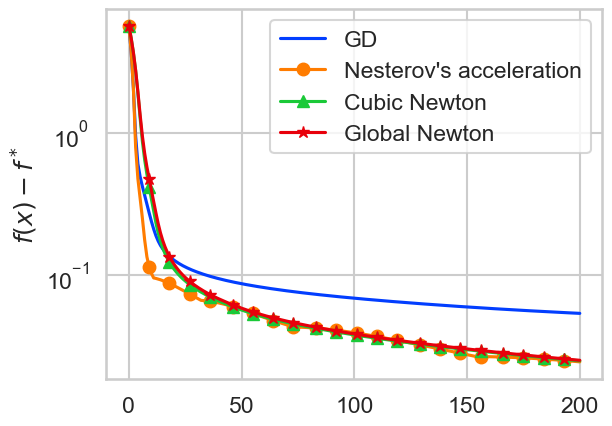

In [7]:
for opt, marker in zip(optimizers_basic, markers):
    opt.trace.plot_losses(marker=marker)
plt.yscale('log')
plt.legend()
plt.savefig(f'logistic_{dataset}_basic.pdf', bbox_inches='tight')

Line search iteration counter is used for plotting GD-Armijo
Line search iteration counter is used for plotting Nesterov-Armijo
Line search iteration counter is used for plotting Newton-Armijo
Line search iteration counter is used for plotting AdaN
Line search iteration counter is used for plotting Arc


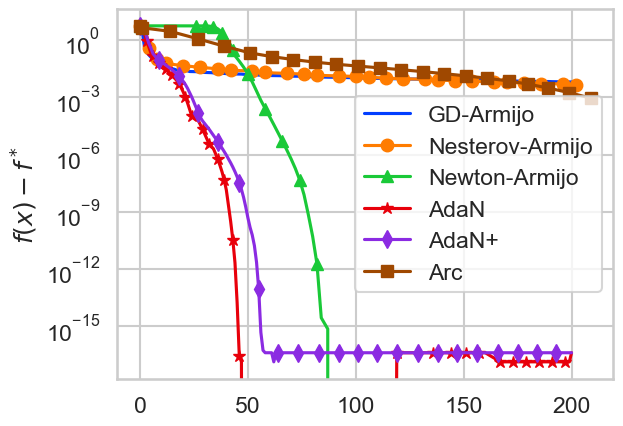

In [8]:
for opt, marker in zip(optimizers_ada, markers):
    opt.trace.plot_losses(f_opt=loss.f_opt, marker=marker)
plt.yscale('log')
plt.legend()
plt.savefig(f'logistic_{dataset}_adaptive.pdf', bbox_inches='tight')

## Hard problem: Log-Sum-Exp

Now we consider the following objective  
$\qquad f(x) = \rho\log\left(\sum_{i=1}^n \exp\left(\frac{a_i^\top x - b_i}{\rho}\right)\right) ,$  
where $a_1,\dotsc, a_n\in\mathbb{R}^d$ are some vectors and $\rho, b_1,\dotsc, b_n, \in \mathbb{R}$ are scalars.

Function $f$ is a smooth approximation of $\max\{a_1^\top x-b_1,\dotsc, a_n^\top x - b_n\}$. Its gradient, Hessian and even higher-order terms have closed-form solutions. The motivation for introducing $\rho$ is simply that it tightens the approximation, namely  
$\qquad \max\{\alpha_1,\dotsc, \alpha_n\} \le \rho\log\left(\sum_{i=1}^n\exp\left(\frac{\alpha_i}{\rho}\right)\right) \le \max\{\alpha_1,\dotsc, \alpha_n\} + \rho \log n,$  
At the same time, $f$ can sometimes be very ill-conditioned, so first-order methods might struggle when minimizing it. In particular, as $\rho$ approaches 0, $f$ becomes much harder to minimize. Below, we are going to use $\rho=0.25$, which, as we will see, too challenging for Newton with Armijo line search.

In [9]:
seed = 0
rng = np.random.default_rng(seed)
n, dim = 500, 200
least_squares_term = False
max_smoothing = 0.05
l2 = 0
loss = LogSumExp(n=n, dim=dim, least_squares_term=least_squares_term, l2=l2, 
                 max_smoothing=max_smoothing)
x0 = rng.normal(scale=0.5, size=dim)

In [10]:
optimizers_basic = setup_basic_optimizers(loss)
optimizers_ada = setup_adaptive_optimizers(loss)

it_max = 4000

for opt in optimizers_basic:
    print(f'Running optimizer: {opt.label}')
    opt.run(x0=x0, it_max=it_max)
    opt.compute_loss_of_iterates()
    
it_max = 1500
    
for opt in optimizers_ada:
    print(f'Running optimizer: {opt.label}')
    opt.run(x0=x0, it_max=it_max)
    opt.compute_loss_of_iterates()

Running optimizer: GD
Running optimizer: Nesterov's acceleration
Running optimizer: Cubic Newton
Running optimizer: Global Newton
Running optimizer: GD-Armijo
Running optimizer: Nesterov-Armijo
Running optimizer: Newton-Armijo
Running optimizer: AdaN
Running optimizer: AdaN+
Running optimizer: Arc


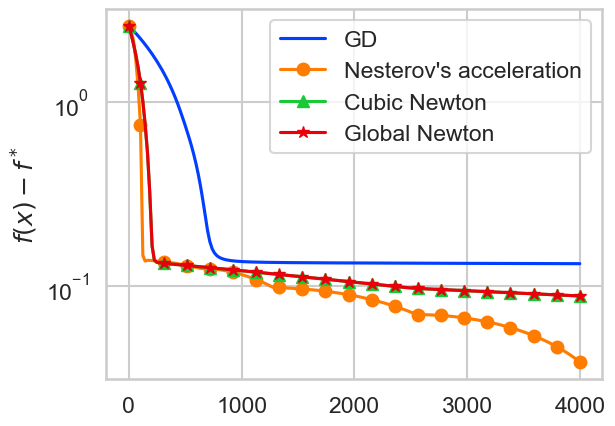

In [11]:
for opt, marker in zip(optimizers_basic, markers):
    opt.trace.plot_losses(marker=marker)
plt.yscale('log')
plt.legend()
plt.savefig(f'logsumexp_{max_smoothing}_basic.pdf', bbox_inches='tight')

Line search iteration counter is used for plotting GD-Armijo
Line search iteration counter is used for plotting Nesterov-Armijo
Line search iteration counter is used for plotting Newton-Armijo
Line search iteration counter is used for plotting AdaN
Line search iteration counter is used for plotting Arc


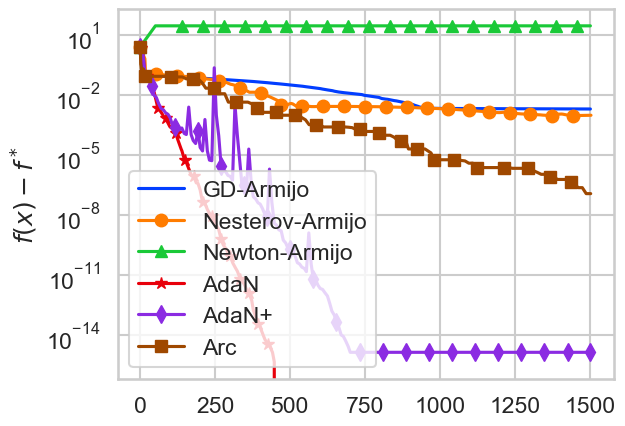

In [12]:
for opt, marker in zip(optimizers_ada, markers):
    opt.trace.plot_losses(marker=marker)
plt.yscale('log')
plt.legend()
plt.savefig(f'logsumexp_{max_smoothing}_adaptive.pdf', bbox_inches='tight')

## Source code links
Here we provide links to the source code of the new methods and objective functions:  
[The method](https://github.com/konstmish/opt_methods/blob/master/optmethods/second_order/reg_newton.py#L19)  
[The line search](https://github.com/konstmish/opt_methods/blob/master/optmethods/line_search/reg_newton_ls.py)  
[Logistic regression oracle](https://github.com/konstmish/opt_methods/blob/master/optmethods/loss/logistic_regression.py) that produces gradients and Hessians  
[Log-sum-exp oracle](https://github.com/konstmish/opt_methods/blob/master/optmethods/loss/log_sum_exp.py) that produces gradients and Hessians

## Conclusions
From both examples, we can see that second-order method with estimation of smoothness (Newton-Armijo, AdaN, AdaN+) work much better for both problems. However, Newton-Armijo fails to solve the second problem due to its ill-conditioning. It is also pedagogical to try to remove $\ell_2$ regularization from the first example, in which case Newton-Armijo would fail because of numpy.linalg solver complaining about the singularity of the Hesssian. To conclude, even though on many problems standard Newton method is already sufficient, there are many others where it is not, and AdaN offers a stable replacement.

-------